# URAP STEM Persistence 

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import datetime
import math
import scipy
import sys
import re

from matplotlib import cm

In [3]:
# feel free to uncomment the options below if you want to manually inspect certain dataframes
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', 100)

plt.rcParams["figure.figsize"]= 20,7.5
plt.rcParams['font.size']= 18

### Loading Data
* `URAP Golden.csv`: a data file with 18,224 individuals with graduation years ranging from 1997 to 2023. This is a file that was manually cultivated based on 2 data sources receieved from the Campus Data Solutions team:
    * `URAP Race.csv`: receieved from the campus data solutions team that is a subset of the CADs data. It is already pre-filtered by the students who have participated in the URAP program, with participation being logged on CADs. This dataset had no NaN CLASSYR rows.
    * `URAP Name.csv`: new file from CADs that has 3,926 additional individuals that was matched based on first/last name and then cleaned
        * There are 202 rows that have missing CLASSYR (ie. graduation years). Upon inspection, all 202 of these individuals didn't seem to be UC Berkeley Students, but visiting scholars (ie. 'ATU UC Los Angeles Visitor', 'ATU UC Santa Cruz Visitor', etc). These 202 people were dropped.
* `Multi_Row_Race_Extracted.csv`: this is a file that is a subset of the Multi-row Data of all UC Berkeley Alumni that LiveAlumni sent us. This extracted file only contains the individuals with a Constituent ID that was also about of the individuals in `URAP Golden.csv`
* `companyInfo.csv`: this file is a relational mapping mainly used to associate a company with a industry based on the company name. The only criteria for this file is that both Company Name and Company Industry cannot be Null.

In [4]:
gold = pd.read_csv(r"C:\Users\S\Desktop\URAP_Golden.csv") 
# Note: this LiveAlumni data is already prefiltered to only contain matching IDs from Golden
live_alumni_multi_row = pd.read_csv(r"C:\Users\S\Desktop\Multi_Row_Golden.csv")
company_info = pd.read_csv(r"C:\Users\S\Desktop\companyInfo.csv")
gpa = pd.read_excel(r"C:\Users\S\Desktop\Apprentices Archive.xlsx")

c:\users\s\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# explore gold data
gold.head()

,Unnamed: 0,ENTITY_ID,CLASSYR,GENDER,EMPLOYER,ethnicity,DEGREES,joined_uerap
0,0,632212,1997,F,NaN,Asian,B.A. Human Biodynamics 1997,1996-09-01
1,1,634006,2002,F,NaN,Decline to State,B.A. English 2002; B.A. German 2002,2001-02-01
2,2,673221,1999,F,NaN,Other,B.A. Molecular & Cell Bio: Genetics 1999,1997-02-01
3,3,699761,2002,F,NaN,White,B.A. Integrative Biology 2002,2002-02-01
4,4,718174,2005,M,NaN,Decline to State,B.A. Applied Mathematics 2005; B.A. Economics ...,2004-02-01


In [6]:
live_alumni_multi_row.head()

,Unnamed: 0,Constituent ID,Full Name,Url,City,State,Country,Industry,FirstName,MiddleName,LastName,Nickname,University,Degree,Major,Start Date,EndDate,CompanyName,Company ID,Title,StartYear,StartMonth,EndYear,EndMonth,Current/Past,Suggested Primary - Needs Validation,Prefix
0,43,976381,Daniel Ganz,https://www.linkedin.com/in/danieljganz,Irvine,California,USA,Higher Education,Daniel,NaN,Ganz,NaN,"University of California, Berkeley",Bachelor’s Degree,"Economics, Legal Studies",2009.0,2012.0,Poplicus,NaN,Senior Business Analyst,2012.0,10.0,2015.0,8.0,P,False,NaN
1,44,976381,Daniel Ganz,https://www.linkedin.com/in/danieljganz,Irvine,California,USA,Higher Education,Daniel,NaN,Ganz,NaN,Leigh High School,High School,NaN,2005.0,2009.0,UC Berkeley Ethnic Studies Library,NaN,Circulation Assistant,2009.0,8.0,2011.0,7.0,P,False,NaN
2,45,976381,Daniel Ganz,https://www.linkedin.com/in/danieljganz,Irvine,California,USA,Higher Education,Daniel,NaN,Ganz,NaN,"University of California, Irvine",Doctor of Philosophy (Ph.D.),Economics,2015.0,2022.0,UC Berkeley Ethnic Studies Library,NaN,Circulation Supervisor II,2011.0,8.0,2012.0,5.0,P,False,NaN
3,46,976381,Daniel Ganz,https://www.linkedin.com/in/danieljganz,Irvine,California,USA,Higher Education,Daniel,NaN,Ganz,NaN,"University of California, Irvine",Juris Doctor (J.D.),Law,2016.0,2021.0,UC Berkeley Undergraduate Research Apprentice ...,NaN,Research Apprentice,2011.0,2.0,2011.0,12.0,P,False,NaN
4,47,976381,Daniel Ganz,https://www.linkedin.com/in/danieljganz,Irvine,California,USA,Higher Education,Daniel,NaN,Ganz,NaN,NaN,NaN,NaN,NaN,NaN,"California Fourth District Court of Appeal, Di...",NaN,Judicial Extern,2017.0,6.0,2017.0,8.0,P,False,NaN


In [7]:
company_info.head()

,Employment Company Name,Company Record Name,Company Industry Name,Company Details Size,Company Type Type,Company Record Matched Company ID,_TotalCount_
0,"""Explore the Pearl"", published for the Pearl D...",Pearl District Business Association,Executive Office,51-200 employees,Non Profit,NaN,223056
1,"""K"" line (Kawasaki Kisen Kaisha, Ltd)","""K""​ line (Kawasaki Kisen Kaisha, Ltd)",Logistics and Supply Chain,5001-10000 employees,Public Company,3693273,223056
2,#waywire,Waywire Networks,Internet,11-50 employees,Privately Held,NaN,223056
3,& DE BANDT,& DE BANDT,Legal Services,11-50 employees,Privately Held,NaN,223056
4,((( onion ))),((( onion ))),Design,NaN,Public Company,3666481,223056


In [8]:
gpa.head()

,Project Term,Last Name,First Name,Standing,Transfer,gpa
0,Fall 2012,DiRocco,Alyson,Sophomore,NaN,3.707
1,Fall 2012,Aung,Kelvin,Junior,NaN,3.387
2,Fall 2012,Vancil,Stephanie,Junior,NaN,3.469
3,Fall 2012,Osadchiy,Vadim,Freshman,NaN,4.0
4,Fall 2012,Vassalo,Brian,Senior,Fall 11,3.533


In [9]:
# get a sense of how big each dataset is
print(len(gold), len(live_alumni_multi_row), len(company_info), len(gpa))

18224 54270 223056 16222


In [10]:
# here is something wierd, we expect the length of 
len(gold[gold['CLASSYR']>=2012])

13496

### Cleaning Data

In [11]:
gold["joined_uerap"].isna().sum()

4065

In [12]:
# Extracting only the year from the race `joined_uerap` column
gold["URAP_Year"] = gold["joined_uerap"].astype(str).apply(lambda x: x[:4])
gold.head()

,Unnamed: 0,ENTITY_ID,CLASSYR,GENDER,EMPLOYER,ethnicity,DEGREES,joined_uerap,URAP_Year
0,0,632212,1997,F,NaN,Asian,B.A. Human Biodynamics 1997,1996-09-01,1996
1,1,634006,2002,F,NaN,Decline to State,B.A. English 2002; B.A. German 2002,2001-02-01,2001
2,2,673221,1999,F,NaN,Other,B.A. Molecular & Cell Bio: Genetics 1999,1997-02-01,1997
3,3,699761,2002,F,NaN,White,B.A. Integrative Biology 2002,2002-02-01,2002
4,4,718174,2005,M,NaN,Decline to State,B.A. Applied Mathematics 2005; B.A. Economics ...,2004-02-01,2004


In [13]:
# split the undergraduate degree
multi_major = gold['DEGREES'].str.split(';', expand=True).add_prefix('Degree').fillna(np.nan)
multi_major['Total_degree'] = multi_major.count(axis=1)
multi_major.head()

,Degree0,Degree1,Degree2,Degree3,Degree4,Degree5,Degree6,Total_degree
0,B.A. Human Biodynamics 1997,NaN,NaN,NaN,NaN,NaN,NaN,1
1,B.A. English 2002,B.A. German 2002,NaN,NaN,NaN,NaN,NaN,2
2,B.A. Molecular & Cell Bio: Genetics 1999,NaN,NaN,NaN,NaN,NaN,NaN,1
3,B.A. Integrative Biology 2002,NaN,NaN,NaN,NaN,NaN,NaN,1
4,B.A. Applied Mathematics 2005,B.A. Economics 2005,NaN,NaN,NaN,NaN,NaN,2


In [14]:
multi_major = pd.concat([gold, multi_major], axis=1)
multi_major = multi_major.drop(columns=['DEGREES'], axis=1)
multi_major.head()

,Unnamed: 0,ENTITY_ID,CLASSYR,GENDER,EMPLOYER,ethnicity,joined_uerap,URAP_Year,Degree0,Degree1,Degree2,Degree3,Degree4,Degree5,Degree6,Total_degree
0,0,632212,1997,F,NaN,Asian,1996-09-01,1996,B.A. Human Biodynamics 1997,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,634006,2002,F,NaN,Decline to State,2001-02-01,2001,B.A. English 2002,B.A. German 2002,NaN,NaN,NaN,NaN,NaN,2
2,2,673221,1999,F,NaN,Other,1997-02-01,1997,B.A. Molecular & Cell Bio: Genetics 1999,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3,699761,2002,F,NaN,White,2002-02-01,2002,B.A. Integrative Biology 2002,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,718174,2005,M,NaN,Decline to State,2004-02-01,2004,B.A. Applied Mathematics 2005,B.A. Economics 2005,NaN,NaN,NaN,NaN,NaN,2


In [15]:
# get a sense of the number of degrees URAP participants have
num_majors = multi_major['Total_degree'].unique()
multi_major_count = pd.DataFrame(multi_major['Total_degree'].value_counts())
multi_major_count['Percentage(%)'] = multi_major_count['Total_degree']/len(multi_major)*100
multi_major_count

,Total_degree,Percentage(%)
1,11100,60.908692
2,5910,32.429763
3,1035,5.679324
4,156,0.856014
5,19,0.104258
6,3,0.016462
7,1,0.005487


In [16]:
multi_major_count_gender = pd.DataFrame(multi_major.groupby(['Total_degree', 'GENDER'])['Total_degree'].count())
multi_major_count_gender

Total_degree
Total_degree GENDER              
1            D                  2
             F               6915
             M               4115
             U                 64
             X                  4
2            D                  1
             F               3665
             M               2173
             U                 64
             X                  7
3            F                605
             M                403
             U                 26
             X                  1
4            F                 73
             M                 74
             U                  8
             X                  1
5            F                  8
             M                 11
6            F                  1
             M                  2
7            F                  1

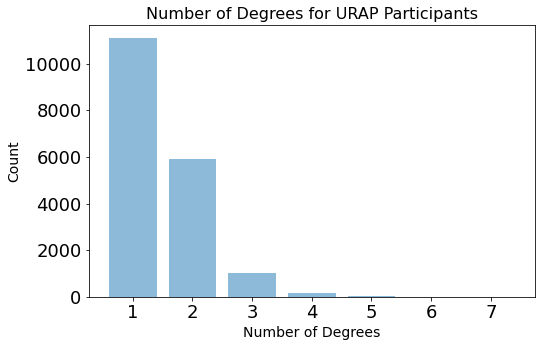

In [17]:
plt.rcParams["figure.figsize"] = (8,5)
plt.bar(num_majors, multi_major_count['Total_degree'], align='center', alpha=0.5)
plt.xlabel('Number of Degrees', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Number of Degrees for URAP Participants', fontsize=16)
plt.show()

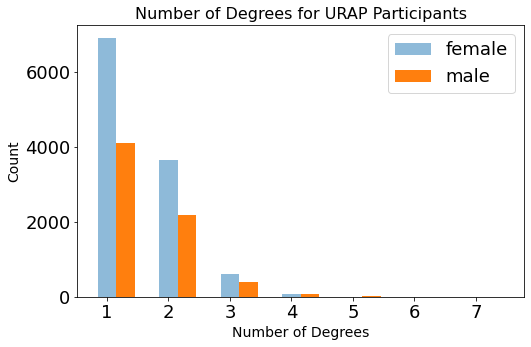

In [18]:
width = 0.3
multi_major_count_female = [6915, 3665, 605, 73, 8, 1, 1]
multi_major_count_male = [4115, 2173, 403, 74, 11, 2, 0]
plt.rcParams["figure.figsize"] = (8,5)
plt.bar(num_majors, multi_major_count_female, align='center', alpha=0.5, width=width)
plt.bar(num_majors + width, multi_major_count_male, width=width)
plt.xlabel('Number of Degrees', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Number of Degrees for URAP Participants', fontsize=16)
plt.legend(labels=['female', 'male'])
plt.show()

In [19]:
gold_gender_dist = pd.DataFrame(gold.groupby('GENDER')['ENTITY_ID'].count())
gold_gender_dist['Percentage(%)'] = gold_gender_dist['ENTITY_ID']/len(gold)*100
gold_gender_dist

,ENTITY_ID,Percentage(%)
GENDER,,
D,3,0.016462
F,11268,61.830553
M,6778,37.192713
U,162,0.888938
X,13,0.071335


In [20]:
gold_ethnicity_dist = pd.DataFrame(gold.groupby('ethnicity')['ENTITY_ID'].count())
gold_ethnicity_dist['Percentage(%)'] = gold_ethnicity_dist['ENTITY_ID']/len(gold)*100
gold_ethnicity_dist

,ENTITY_ID,Percentage(%)
ethnicity,,
African American,373,2.046752
Asian,9264,50.834065
Chicano/Latino,1770,9.712467
Decline to State,1235,6.776778
Native American/Alaska Native,84,0.460931
Other,50,0.274363
Pacific Islander,33,0.181080
White,5404,29.653205


In [21]:
len(gold['ENTITY_ID'].unique())
# The number of unique ID is equal to the number of ID in URAP golden dataset
# This indicates that there is only one record for each URAP participants
# What about student with multiple URAP participation during undergraduate? Did they update each student URAP participation info every time?

18224

The following merge is to try to associate the company name with the company industry. However, there are about ~10k rows that do not have a matching mapping for the Company Name Given. For now, we will drop these (by taking an inner join).

In [22]:
live_alumni_multi_row_industry = live_alumni_multi_row.merge(company_info[["Employment Company Name", "Company Industry Name"]], 
                            left_on = "CompanyName", right_on = "Employment Company Name", how="inner")
#.dropna(subset=["StartYear", "Company Industry Name"])

In [23]:
la_individual = live_alumni_multi_row_industry #.groupby("Constituent ID").agg(list)#.agg(unique)
print(len(la_individual))
la_individual.head(2)

101229


,Unnamed: 0,Constituent ID,Full Name,Url,City,State,Country,Industry,FirstName,MiddleName,LastName,Nickname,University,Degree,Major,Start Date,EndDate,CompanyName,Company ID,Title,StartYear,StartMonth,EndYear,EndMonth,Current/Past,Suggested Primary - Needs Validation,Prefix,Employment Company Name,Company Industry Name
0,43,976381,Daniel Ganz,https://www.linkedin.com/in/danieljganz,Irvine,California,USA,Higher Education,Daniel,NaN,Ganz,NaN,"University of California, Berkeley",Bachelor’s Degree,"Economics, Legal Studies",2009.0,2012.0,Poplicus,NaN,Senior Business Analyst,2012.0,10.0,2015.0,8.0,P,False,NaN,Poplicus,Information Services
1,44,976381,Daniel Ganz,https://www.linkedin.com/in/danieljganz,Irvine,California,USA,Higher Education,Daniel,NaN,Ganz,NaN,Leigh High School,High School,NaN,2005.0,2009.0,UC Berkeley Ethnic Studies Library,NaN,Circulation Assistant,2009.0,8.0,2011.0,7.0,P,False,NaN,UC Berkeley Ethnic Studies Library,Higher Education


In [24]:
# combining both la_invidual with the URAP race dataset
merged = gold.merge(la_individual.reset_index(), left_on = "ENTITY_ID", right_on = "Constituent ID", how = "inner")
merged.head(2)

,Unnamed: 0_x,ENTITY_ID,CLASSYR,GENDER,EMPLOYER,ethnicity,DEGREES,joined_uerap,URAP_Year,index,Unnamed: 0_y,Constituent ID,Full Name,Url,City,State,Country,Industry,FirstName,MiddleName,LastName,Nickname,University,Degree,Major,Start Date,EndDate,CompanyName,Company ID,Title,StartYear,StartMonth,EndYear,EndMonth,Current/Past,Suggested Primary - Needs Validation,Prefix,Employment Company Name,Company Industry Name
0,5,724202,2001,F,NaN,White,B.S. Business Administration 2001,2000-09-01,2000,8231,147090,724202,Bonnie Salkhi,https://www.linkedin.com/in/bonnie-salkhi-8219...,San Francisco,California,USA,Accounting,Bonnie,NaN,Salkhi,NaN,"Haas School of Business, UC Berkeley",Bachelor of Science (BS),Business Administration,1999.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Education Management
1,5,724202,2001,F,NaN,White,B.S. Business Administration 2001,2000-09-01,2000,8232,147090,724202,Bonnie Salkhi,https://www.linkedin.com/in/bonnie-salkhi-8219...,San Francisco,California,USA,Accounting,Bonnie,NaN,Salkhi,NaN,"Haas School of Business, UC Berkeley",Bachelor of Science (BS),Business Administration,1999.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wireless


In [25]:
len(merged)

101229

In [26]:
merged.columns

Index(['Unnamed: 0_x', 'ENTITY_ID', 'CLASSYR', 'GENDER', 'EMPLOYER',
       'ethnicity', 'DEGREES', 'joined_uerap', 'URAP_Year', 'index',
       'Unnamed: 0_y', 'Constituent ID', 'Full Name', 'Url', 'City', 'State',
       'Country', 'Industry', 'FirstName', 'MiddleName', 'LastName',
       'Nickname', 'University', 'Degree', 'Major', 'Start Date', 'EndDate',
       'CompanyName', 'Company ID', 'Title', 'StartYear', 'StartMonth',
       'EndYear', 'EndMonth', 'Current/Past',
       'Suggested Primary - Needs Validation', 'Prefix',
       'Employment Company Name', 'Company Industry Name'],
      dtype='object')

In [27]:
merged["ENTITY_ID"].equals(merged["Constituent ID"])

True

In [28]:
# This is the amount of students who have URAP participation and Linkedin information
len(merged.groupby("ENTITY_ID").count())

7846

# Manual Classification
There are two things that we need to classify/extract:
* STEM vs. Non-STEM Degrees
* STEM vs. Non-STEM Jobs and Industries
* Graduate vs. Non-Graduate Academic Degrees
    * Currently we do not do any farther analysis with this, as we ran out of time


### STEM vs. Non-STEM Degrees
Only extracting degrees that follow the format of `B.A./B.S. {Degree} YYYY` Pattern

In [29]:
# getting all the possible B.A. Degrees that exist in this dataset
# don't need to extract B.S. Degree since we assume that B.S. == STEM

# Uncomment below to see all possible B.A. Degrees
set(gold["DEGREES"].str.split(';').explode().str.extract(r"B\.A\. (.+)+\d{4}").dropna()[0])

# Old option where we extract both B.S. and B.A. Degrees
# set(race["DEGREES"].str.split(';').explode().str.extract(r"(B\.A\.|B\.S\.) (.+)+\d{4}").dropna()[1])

{'African American Plan A: SocSci ',
 'African American Studies ',
 'American Studies ',
 'Anc Egypt & Near East Art/Arch ',
 'Ancient Near East Archaeology/Hist ',
 'Anthropology ',
 'Applied Mathematics ',
 'Architecture ',
 'Art Practice ',
 'Asian American & Asian Diaspora ',
 'Asian American Studies ',
 'Asian Studies ',
 'Asian Studies I: China ',
 'Asian Studies II: Japan ',
 'Astrophysics ',
 'Atmospheric Science ',
 'Bus Ad/Evening & Weekend MBA ',
 'Business Administration ',
 'Celtic Studies ',
 'Chemistry ',
 'Chicano Studies ',
 'Chinese Language ',
 'City & Regional Planning ',
 'Classical Civilizations ',
 'Classical Languages ',
 'Cognitive Science ',
 'Comparative Literature ',
 'Computer Science ',
 'Dance & Performance Studies ',
 'Data Science ',
 'Development Studies ',
 'Dramatic Art: Dance ',
 'Dutch Studies ',
 'E Asian Rel, Thought, & Cul ',
 'Economics ',
 'English ',
 'Envir Science I: Physical Sci ',
 'Environmental Earth Science ',
 'Environmental Econ & Po

In [30]:
# According to: https://www.heri.ucla.edu/PDFs/surveyAdmin/fac/Listing-of-STEM-Disciplines.pdf
BA_STEM_degrees = [
    'Applied Mathematics',
    'Architecture',
    'Astrophysics',
    'Atmospheric Science',
    'Chemistry',
    'City & Regional Planning', # new
    'Cognitive Science',
    'Computer Science',
    'Data Science ',
#     'Economics ',
    'Envir Science I: Physical Sci',
    'Environmental Earth Science',
    'Environmental Econ & Policy',
    'Environmental Sciences',
    'Environmental Studies', # new
#     'Geography ',
    'Geology',
    'Geophysics',
    'Human Biodynamics',
    'Integrative Biology',
#     'Linguistics ',
    'Marine Science',
    'Mathematics',
    'Microbiology & Immunology', # new
    'Molecular & Cell Bio: Biochem/Molecular',
    'Molecular & Cell Bio: Cell & Development',
    'Molecular & Cell Bio: Genetics',
    'Molecular & Cell Bio: Immunology',
    'Molecular & Cell Bio: Neurobiology',
    'Molecular & Cell Biology',
    'Physical Sciences',
    'Physics',
    'Planetary Science',
    'Psychology',
    'Public Health',
    'Statistics',
    'Sustainable Environmental Design',

]

In [31]:
# Uncomment below to see all possible B.S. Degrees
BS_STEM_degrees = set(gold["DEGREES"].str.split(';').explode().str.extract(r"B\.S\. (.+)+\d{4}").dropna()[0])
BS_STEM_degrees 

{'Bioengineering ',
 'Bioengr & Mat Sci & Engr ',
 'Bioresource Sciences ',
 'Business Administration ',
 'Chemical Biology ',
 'Chemical Engineering ',
 'Chemical Engr & Material Sci & Engr ',
 'Chemical Engr & Nuclear Engr ',
 'Chemistry ',
 'Civil Engineering ',
 'Computational Engineering ',
 'Conservation/Resource Studies ',
 'EECS & Material Sci & Engr ',
 'EECS & Nuclear Engr ',
 'Eco Mgmt & Forestry - Forestry ',
 'Eco Mgmt & Forestry - Nat Resource Mgmt ',
 'Electrical Engr & Comp Sci: Undergrad ',
 'Energy Engineering ',
 'Engineering Physics ',
 'Engr Math & Statistics ',
 'Environmental Econ & Policy ',
 'Environmental Engr Science ',
 'Environmental Sciences ',
 'Environmental Studies ',
 'Forestry & Natural Resources ',
 'Genetics & Plant Biology ',
 'Geology ',
 'Industrial Engr/Operations Rsh Undergrad ',
 'Materials Sci & Engr & Mech Engr ',
 'Materials Science & Engineering ',
 'Mech Engr & Nuclear Engr ',
 'Mechanical Engineering: Undergrad ',
 'Microbial Biology ',


### STEM vs. Non-STEM Jobs
Remember that there are about ~10k job rows that are missing a company industry

In [32]:
# Uncomment below to see all possible Company Industries
set(live_alumni_multi_row_industry["Company Industry Name"].explode())

{'Accounting',
 'Airlines/Aviation',
 'Alternative Dispute Resolution',
 'Alternative Medicine',
 'Animation',
 'Apparel & Fashion',
 'Architecture & Planning',
 'Arts and Crafts',
 'Automotive',
 'Aviation & Aerospace',
 'Banking',
 'Biotechnology',
 'Broadcast Media',
 'Building Materials',
 'Business Supplies and Equipment',
 'Capital Markets',
 'Chemicals',
 'Civic & Social Organization',
 'Civil Engineering',
 'Commercial Real Estate',
 'Computer & Network Security',
 'Computer Games',
 'Computer Hardware',
 'Computer Networking',
 'Computer Software',
 'Construction',
 'Consumer Electronics',
 'Consumer Goods',
 'Consumer Services',
 'Cosmetics',
 'Dairy',
 'Defense & Space',
 'Design',
 'E-Learning',
 'Education Management',
 'Electrical/Electronic Manufacturing',
 'Entertainment',
 'Environmental Services',
 'Events Services',
 'Executive Office',
 'Facilities Services',
 'Farming',
 'Financial Services',
 'Fine Art',
 'Fishery',
 'Food & Beverages',
 'Food Production',
 'Fund-

In [33]:
STEM_company_industry = [
    'Accounting',
    'Airlines/Aviation',
    'Alternative Medicine',
    'Animation',
    'Architecture & Planning',
    'Automotive',
    'Aviation & Aerospace',
    'Banking',
    'Biotechnology',
    'Chemicals',
    'Civil Engineering',
    'Computer & Network Security',
    'Computer Games',
    'Computer Hardware',
    'Computer Networking',
    'Computer Software',
    'Construction',
    'Consumer Electronics',
    'Defense & Space',
    'Design',
    'E-Learning',
    'Electrical/Electronic Manufacturing',
    'Environmental Services',
    'Food Production',
    'Hospital & Health Care',
    'Industrial Automation',
    'Information Services',
    'Information Technology and Services',
    'Internet',
    'Logistics and Supply Chain',
    'Machinery',
    'Mechanical or Industrial Engineering',
    'Medical Devices',
    'Medical Practice',
    'Museums and Institutions',
    'Nanotechnology',
    'Oil & Energy',
    'Pharmaceuticals',
    'Plastics',
    'Renewables & Environment',
    'Semiconductors',
    'Telecommunications',
    'Utilities',
    'Veterinary',
    'Wireless',
]

### Graduate Degrees
Currently, we only consider a degree to be a Graduate Degree if it is a Masters, PhD or J.D. degree.

WE CURRENTLY DO NOT DO ANY ANALYSIS WITH THIS!

In [34]:
la_degrees = la_individual["Degree"].explode().dropna()
# proxy for Masters and Ph.D Degrees
m_p_in = la_degrees.apply(lambda x: ("m" in x.lower()) or ("p" in x.lower()))
master_phd_in = la_degrees.apply(lambda x: 
                                 (
                                     ("m." in x.lower()) or
                                     ("master" in x.lower()) or
                                     ("md" in x.lower()) or
                                     ("m.d." in x.lower()) or
                                     ("ph.d" in x.lower()) or
                                     ("phd" in x.lower()) or
                                     ("p.h.d" in x.lower()) or
                                     ("jd" in x.lower()) or
                                     ("j.d." in x.lower())
                                 )
                                 and 
                                 (
                                     not(x == "Headmaster's Honors List") and
                                     not(x =='Negotiation Mastery: Unlocking Value in the Real world')
                                 )
                             )
# set(la_degrees[m_p_in]) - set(la_degrees[master_phd_in])
# print(len(set(la_degrees[master_phd_in])))
# set(la_degrees[master_phd_in])


In [35]:
la_individual['master_phd']=master_phd_in
la_higher_educ = la_individual[la_individual['master_phd']==True]
la_higher_educ_ID = la_higher_educ['Constituent ID'].unique()
len(la_higher_educ_ID)

2539

In [36]:
merged_degree = merged['Degree'].dropna().unique()
np.set_printoptions(threshold=sys.maxsize)
print(merged_degree)

['Bachelor of Science (BS)' 'BA' 'JD' 'M.S' 'MS' 'Engineering' 'B.A.'
 "Bachelor's degree" 'Bachelor of Science (B.S.)'
 'Doctor of Medicine (MD) Candidate' 'Post-baccalaureate studies'
 'Legal Assistant/Paralegal' 'Associate of Science - AS'
 'Master of Science - MS' 'Certificate' 'Taxation' 'Ph.D.' 'MSc' 'BS'
 'MPH' 'Bachelor of Arts (B.A.)' 'Teaching Crednetial'
 'BA, with high honors' 'Ph.D' 'B.S.'
 'PhD ABD (on leave - all but dissertation completed)' 'BAs'
 'Lester Center for Entrepreneurship - Lean Startup Accelerator' 'PhD'
 'BS, PhD and Posdoc' 'MCM' 'B.S., B.A.' 'M.P.A'
 'Doctor of Philosophy (Ph.D.)' 'Founder' 'History' 'High School Diploma'
 'Master of Philosophy (M.Phil.)' 'Doctor of Philosophy (PhD)'
 'Bachelor of Arts (B.A.) Highest Honors' 'MA (RCA)'
 'Doctor of Philosophy' 'Bachelor of Science'
 'Master of Business Administration (MBA)' 'Master of Arts - MA'
 'Doctor of Law (J.D.)' 'Master of Business Administration (M.B.A.)'
 'Doctor of Philosophy - PhD' 'Master of Sc

In [37]:
higher_educ_str = r'MS|M\.S|M\.S\.|ms|Master|master|JD|J\.D\.|J\.D|MD|Ph\.D\.|PhD|Ph\.D|phd|ph\.d|Doctor|doctor'

def higher_education(array):
    output = []
    for entry in array:
        if len(re.findall(higher_educ_str, str(entry)))!= 0:
            output.append(True)
        else:
            output.append(False)
    return output

degree = merged['Degree'].to_list()
higher_educ = higher_education(degree)
merged['higher_educ']=higher_educ

In [38]:
higher_education = merged[merged['higher_educ']==True]
higher_education_ID = higher_education['ENTITY_ID'].unique()
len(higher_education_ID)

2661

In [39]:
a = [1,2,3,4,5]
b = [1,3,5,6]
intersection = list(set(a) & set(b))
union = list(set(a) | set(b))
c = [elem in intersection for elem in b]
index = [i for i, x in enumerate(c) if not x]
[b[d] for d in index]

[6]

In [40]:
intersection = list(set(la_higher_educ_ID)&set(higher_education_ID))
union = list(set(la_higher_educ_ID)|set(higher_education_ID))
boolean = [elem in intersection for elem in la_higher_educ_ID]
index = [i for i, x in enumerate(boolean) if not x]
missing_ID = [la_higher_educ_ID[j] for j in index]

In [41]:
merged['higher_educ']=pd.DataFrame(merged['ENTITY_ID']).isin(higher_education_ID).any(1)
merged.head(2)

,Unnamed: 0_x,ENTITY_ID,CLASSYR,GENDER,EMPLOYER,ethnicity,DEGREES,joined_uerap,URAP_Year,index,Unnamed: 0_y,Constituent ID,Full Name,Url,City,State,Country,Industry,FirstName,MiddleName,LastName,Nickname,University,Degree,Major,Start Date,EndDate,CompanyName,Company ID,Title,StartYear,StartMonth,EndYear,EndMonth,Current/Past,Suggested Primary - Needs Validation,Prefix,Employment Company Name,Company Industry Name,higher_educ
0,5,724202,2001,F,NaN,White,B.S. Business Administration 2001,2000-09-01,2000,8231,147090,724202,Bonnie Salkhi,https://www.linkedin.com/in/bonnie-salkhi-8219...,San Francisco,California,USA,Accounting,Bonnie,NaN,Salkhi,NaN,"Haas School of Business, UC Berkeley",Bachelor of Science (BS),Business Administration,1999.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Education Management,False
1,5,724202,2001,F,NaN,White,B.S. Business Administration 2001,2000-09-01,2000,8232,147090,724202,Bonnie Salkhi,https://www.linkedin.com/in/bonnie-salkhi-8219...,San Francisco,California,USA,Accounting,Bonnie,NaN,Salkhi,NaN,"Haas School of Business, UC Berkeley",Bachelor of Science (BS),Business Administration,1999.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wireless,False


In [42]:
gold['higher_educ']=pd.DataFrame(gold['ENTITY_ID']).isin(higher_education_ID).any(1)
gold_higher_educ = gold[gold['higher_educ']==True]

count_higher_educ_CLASSYR = gold_higher_educ.groupby('CLASSYR')['higher_educ'].count().to_frame()
count_gold_CLASSYR = gold.groupby('CLASSYR')['ENTITY_ID'].count().to_frame()

In [43]:
count_higher_educ = count_gold_CLASSYR.merge(count_higher_educ_CLASSYR, left_on='CLASSYR', right_on="CLASSYR", how='outer')
count_higher_educ

,ENTITY_ID,higher_educ
CLASSYR,,
1987,1,NaN
1989,1,NaN
1992,1,NaN
1994,1,NaN
1996,1,NaN
1997,19,1.0
1998,89,8.0
1999,94,16.0
2000,131,27.0


In [44]:
# student graduate from recent years might still be in the process of pursuing education
# so we only use CLASSYR from 2000 to 2015 (16 years of data)
count_higher_educ = count_higher_educ.iloc[8:24, :]
count_higher_educ['percentage(%)'] = count_higher_educ['higher_educ']/count_higher_educ['ENTITY_ID']*100
count_higher_educ

C:\Users\S\AppData\Local\Temp/ipykernel_12396/2654831458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_higher_educ['percentage(%)'] = count_higher_educ['higher_educ']/count_higher_educ['ENTITY_ID']*100


,ENTITY_ID,higher_educ,percentage(%)
CLASSYR,,,
2000,131,27.0,20.610687
2001,92,12.0,13.043478
2002,135,25.0,18.518519
2003,177,42.0,23.728814
2004,168,39.0,23.214286
2005,268,46.0,17.164179
2006,383,69.0,18.015666
2007,466,119.0,25.536481
2008,463,116.0,25.053996


In [45]:
higher_educ_female = gold_higher_educ[gold_higher_educ['GENDER']=='F']
count_higher_educ_CLASSYR_female = higher_educ_female.groupby('CLASSYR')['higher_educ'].count().to_frame() 
gold_female = gold[gold['GENDER']=='F']
count_gold_CLASSYR_female = gold.groupby('CLASSYR')['ENTITY_ID'].count().to_frame()
count_higher_educ_female = count_gold_CLASSYR_female.merge(count_higher_educ_CLASSYR_female, 
                                                           left_on='CLASSYR', right_on="CLASSYR", how='outer')
count_higher_educ_female = count_higher_educ_female.iloc[8:24, :]
count_higher_educ_female['percentage(%)'] = count_higher_educ_female['higher_educ']/count_higher_educ_female['ENTITY_ID']*100
count_higher_educ_female

,ENTITY_ID,higher_educ,percentage(%)
CLASSYR,,,
2000,131,13.0,9.923664
2001,92,8.0,8.695652
2002,135,15.0,11.111111
2003,177,27.0,15.254237
2004,168,19.0,11.309524
2005,268,20.0,7.462687
2006,383,32.0,8.355091
2007,466,64.0,13.733906
2008,463,53.0,11.447084


In [46]:
higher_educ_male = gold_higher_educ[gold_higher_educ['GENDER']=='M']
count_higher_educ_CLASSYR_male = higher_educ_male.groupby('CLASSYR')['higher_educ'].count().to_frame() 
gold_male = gold[gold['GENDER']=='M']
count_gold_CLASSYR_male = gold.groupby('CLASSYR')['ENTITY_ID'].count().to_frame()
count_higher_educ_male = count_gold_CLASSYR_male.merge(count_higher_educ_CLASSYR_male, 
                                                           left_on='CLASSYR', right_on="CLASSYR", how='outer')
count_higher_educ_male = count_higher_educ_male.iloc[8:24, :]
count_higher_educ_male['percentage(%)'] = count_higher_educ_male['higher_educ']/count_higher_educ_male['ENTITY_ID']*100
count_higher_educ_male

,ENTITY_ID,higher_educ,percentage(%)
CLASSYR,,,
2000,131,14.0,10.687023
2001,92,4.0,4.347826
2002,135,10.0,7.407407
2003,177,15.0,8.474576
2004,168,20.0,11.904762
2005,268,26.0,9.701493
2006,383,37.0,9.660574
2007,466,54.0,11.587983
2008,463,63.0,13.606911


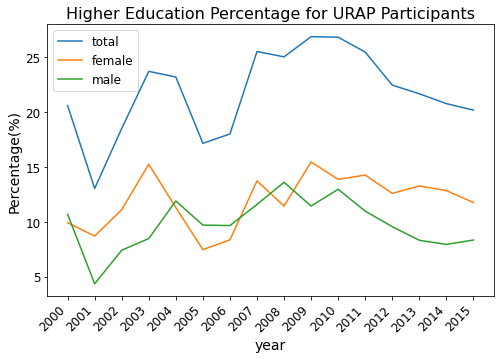

In [47]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(count_higher_educ.index, count_higher_educ['percentage(%)'])
plt.plot(count_higher_educ.index, count_higher_educ_female['percentage(%)'])
plt.plot(count_higher_educ.index, count_higher_educ_male['percentage(%)'])
plt.xlabel('year', fontsize=14)
plt.ylabel('Percentage(%)', fontsize=14)
plt.title('Higher Education Percentage for URAP Participants', fontsize=16)
plt.xticks(count_higher_educ.index, rotation=45, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(labels=['total', 'female','male'], fontsize=12)
plt.show()

## Checking STEM Persistence Within Given Years
Based on the manual classifications defined above, we will look a given number of X years after graduation (assumed to be as `PREF_CLASS_YR`) to see if within X years after graduation an individual has gotten a STEM graduate degree or STEM related job. 

Currently, we only define "persistence" to be if a student with an Undergrad STEM degree gets a job in a STEM Company Industry. We realize that this isn't the most accurate classification of persistence, so a more rigorous classification of "STEM Persistence" is definitely something on the to do list.

In [48]:
def is_STEM_ugrad_degree(degree):
    # helper function to classify if a degree is a STEM degree
    to_match = degree.lower()
    bs = "b.s." in to_match
    ba_stem = any(x.lower() in to_match for x in BA_STEM_degrees)
    
    return (bs or ba_stem)

In [49]:
def is_STEM_job(company_industry):
    # helper function to classify if a company industry is a STEM industry
    if type(company_industry) == float:
        return np.nan
    return company_industry in STEM_company_industry

In [50]:
X_yrs_graduate_degree = 2
Y_yrs_STEM_job = 5

In [51]:
# determining if the degree and the company industry are classfied as a stem
merged["Is STEM Industry"] = merged["Company Industry Name"].apply(is_STEM_job)
merged["Is STEM Degree"] = merged["DEGREES"].apply(is_STEM_ugrad_degree)

In [52]:
merged.head(2)

,Unnamed: 0_x,ENTITY_ID,CLASSYR,GENDER,EMPLOYER,ethnicity,DEGREES,joined_uerap,URAP_Year,index,Unnamed: 0_y,Constituent ID,Full Name,Url,City,State,Country,Industry,FirstName,MiddleName,LastName,Nickname,University,Degree,Major,Start Date,EndDate,CompanyName,Company ID,Title,StartYear,StartMonth,EndYear,EndMonth,Current/Past,Suggested Primary - Needs Validation,Prefix,Employment Company Name,Company Industry Name,higher_educ,Is STEM Industry,Is STEM Degree
0,5,724202,2001,F,NaN,White,B.S. Business Administration 2001,2000-09-01,2000,8231,147090,724202,Bonnie Salkhi,https://www.linkedin.com/in/bonnie-salkhi-8219...,San Francisco,California,USA,Accounting,Bonnie,NaN,Salkhi,NaN,"Haas School of Business, UC Berkeley",Bachelor of Science (BS),Business Administration,1999.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Education Management,False,False,True
1,5,724202,2001,F,NaN,White,B.S. Business Administration 2001,2000-09-01,2000,8232,147090,724202,Bonnie Salkhi,https://www.linkedin.com/in/bonnie-salkhi-8219...,San Francisco,California,USA,Accounting,Bonnie,NaN,Salkhi,NaN,"Haas School of Business, UC Berkeley",Bachelor of Science (BS),Business Administration,1999.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wireless,False,True,True


In [53]:
total = merged.copy(deep=True)
# get difference between job start year and and graduation year
total["Yrs_Grad"] = total["StartYear"] - total["CLASSYR"]

#total = total[["ENTITY_ID", "Is STEM Industry", "Is STEM Degree", "Yrs Grad", 'Suggested Primary - Needs Validation']]
# only considering jobs that are within Y amount of years from graduation, as defined above
total = total[(0 <= total["Yrs_Grad"]) & (total["Yrs_Grad"]<= Y_yrs_STEM_job)]
STEM_persistence = total.groupby("ENTITY_ID").agg(any)["Is STEM Industry"]
STEM_persistence = STEM_persistence.rename(f"STEM_Job_in_5Yrs")
total.head()

,Unnamed: 0_x,ENTITY_ID,CLASSYR,GENDER,EMPLOYER,ethnicity,DEGREES,joined_uerap,URAP_Year,index,Unnamed: 0_y,Constituent ID,Full Name,Url,City,State,Country,Industry,FirstName,MiddleName,LastName,Nickname,University,Degree,Major,Start Date,EndDate,CompanyName,Company ID,Title,StartYear,StartMonth,EndYear,EndMonth,Current/Past,Suggested Primary - Needs Validation,Prefix,Employment Company Name,Company Industry Name,higher_educ,Is STEM Industry,Is STEM Degree,Yrs_Grad
14,6,729526,2005,M,NaN,Asian,B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...,2004-02-01,2004,68318,283103,729526,Eugene Park,https://www.linkedin.com/in/eugenejpark,San Francisco,California,USA,Law Practice,Eugene,NaN,Park,NaN,"University of California, Berkeley",BA,NaN,NaN,NaN,"United States District Court, Northern Distric...",NaN,Judicial Extern to Honorable Saundra B. Armstrong,2008.0,5.0,2008.0,8.0,P,False,NaN,"United States District Court, Northern Distric...",Judiciary,True,False,False,3.0
16,6,729526,2005,M,NaN,Asian,B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...,2004-02-01,2004,91398,283106,729526,Eugene Park,https://www.linkedin.com/in/eugenejpark,San Francisco,California,USA,Law Practice,Eugene,NaN,Park,NaN,NaN,NaN,NaN,NaN,NaN,San Francisco Superior Court,NaN,Law Clerk to Honorable Ernest H. Goldsmith,2010.0,8.0,2011.0,11.0,P,False,NaN,San Francisco Superior Court,Judiciary,True,False,False,5.0
18,6,729526,2005,M,NaN,Asian,B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...,2004-02-01,2004,93893,283107,729526,Eugene Park,https://www.linkedin.com/in/eugenejpark,San Francisco,California,USA,Law Practice,Eugene,NaN,Park,NaN,NaN,NaN,NaN,NaN,NaN,Steyer Lowenthal Boodrookas Alvarez & Smith,NaN,Summer Associate,2009.0,5.0,2009.0,8.0,P,False,NaN,Steyer Lowenthal Boodrookas Alvarez & Smith,Law Practice,True,False,False,4.0
20,7,732926,2005,M,NaN,Asian,B.S. Bioengineering 2005,2004-02-01,2004,67786,13120,732926,Vishal Tandon,https://www.linkedin.com/in/vishal-tandon-8a7a...,Boston,Massachusetts,USA,Higher Education,Vishal,NaN,Tandon,NaN,Cornell University,M.S,Biomedical Engineering,2005.0,2007.0,Cornell University,NaN,Graduate Student,2005.0,8.0,2010.0,12.0,P,False,NaN,Cornell University,Hospitality,True,False,True,0.0
21,7,732926,2005,M,NaN,Asian,B.S. Bioengineering 2005,2004-02-01,2004,67787,13120,732926,Vishal Tandon,https://www.linkedin.com/in/vishal-tandon-8a7a...,Boston,Massachusetts,USA,Higher Education,Vishal,NaN,Tandon,NaN,Cornell University,M.S,Biomedical Engineering,2005.0,2007.0,Cornell University,NaN,Graduate Student,2005.0,8.0,2010.0,12.0,P,False,NaN,Cornell University,Higher Education,True,False,True,0.0


In [54]:
total.columns

Index(['Unnamed: 0_x', 'ENTITY_ID', 'CLASSYR', 'GENDER', 'EMPLOYER',
       'ethnicity', 'DEGREES', 'joined_uerap', 'URAP_Year', 'index',
       'Unnamed: 0_y', 'Constituent ID', 'Full Name', 'Url', 'City', 'State',
       'Country', 'Industry', 'FirstName', 'MiddleName', 'LastName',
       'Nickname', 'University', 'Degree', 'Major', 'Start Date', 'EndDate',
       'CompanyName', 'Company ID', 'Title', 'StartYear', 'StartMonth',
       'EndYear', 'EndMonth', 'Current/Past',
       'Suggested Primary - Needs Validation', 'Prefix',
       'Employment Company Name', 'Company Industry Name', 'higher_educ',
       'Is STEM Industry', 'Is STEM Degree', 'Yrs_Grad'],
      dtype='object')

In [55]:
final = merged[["ENTITY_ID", "Full Name","GENDER", "ethnicity", "CLASSYR", "DEGREES", "Is STEM Degree"]].drop_duplicates()
final = final.merge(STEM_persistence, on="ENTITY_ID", how="outer")
final = final.rename(columns={"CLASSYR": "Class Year", "DEGREES": "Degrees", "ethnicity": "Ethnicity", "GENDER": "Gender","ENTITY_ID": "ID"})

# subsequent analysis are better if the truth statements are encoded as floats instead of booleans
final["Is STEM Degree"] = final["Is STEM Degree"].apply(lambda x: float(int(x)))
final["STEM_Job_in_5Yrs"] = final["STEM_Job_in_5Yrs"].apply(lambda x: float(int(x)) if type(x) == bool else np.nan)

In [56]:
consolidated = final
# only getting people who graduated from 2020 and before since past 2020 we have less data
consolidated = consolidated[consolidated["Class Year"] <= 2020]
consolidated

,ID,Full Name,Gender,Ethnicity,Class Year,Degrees,Is STEM Degree,STEM_Job_in_5Yrs
0,724202,Bonnie Salkhi,F,White,2001,B.S. Business Administration 2001,1.0,NaN
1,729526,Eugene Park,M,Asian,2005,B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...,0.0,0.0
2,732926,Vishal Tandon,M,Asian,2005,B.S. Bioengineering 2005,1.0,0.0
3,746450,Marowen Ng,M,Asian,2004,B.S. Nuclear Engineering: Undergrad 2004,1.0,1.0
4,754146,Anthony Bello,M,Decline to State,2007,B.A. Classical Languages 2007; M.A. Design 2012,0.0,NaN
...,...,...,...,...,...,...,...,...
7804,3468738,Tianxing Cao,M,Decline to State,2020,B.A. Global Studies 2020,0.0,NaN
7805,3468968,Alejandro Stefan Zavala,M,Chicano/Latino,2020,B.A. Computer Science 2020,1.0,NaN
7806,3468993,Anushtha Sharma,F,Asian,2020,B.S. Microbial Biology 2020,1.0,0.0
7807,3469873,Phillip Noel Sanvictores,D,Asian,2020,B.A. Integrative Biology 2020,1.0,NaN


In [57]:
consolidated["STEM_Job_in_5Yrs"].isna().sum()

1504

In [58]:
consolidated['Ethnicity'].unique().copy()

array(['White', 'Asian', 'Decline to State', 'African American',
       'Chicano/Latino', 'Other', 'Pacific Islander',
       'Native American/Alaska Native'], dtype=object)

In [59]:
multi_major['ENTITY_ID']=gold['ENTITY_ID']

In [60]:
num_degree = multi_major[['ENTITY_ID', 'Total_degree']]
consolidated = consolidated.dropna().merge(num_degree.reindex(), left_on='ID', right_on='ENTITY_ID', how='inner')
consolidated = consolidated[(consolidated['Gender']=='F')|(consolidated['Gender']=='M')]
consolidated = consolidated[consolidated['Ethnicity']!='Decline to State']
consolidated['Ethnicity'].replace({'African American':'Other', 'Chicano/Latino':'Other', 
                                   'Native American/Alaska Native':'Other','Pacific Islander':'Other'}, inplace=True)
consolidated['White'] = consolidated['Ethnicity'].copy()
consolidated['Non_W/A'] = consolidated['Ethnicity']

consolidated['Gender'].replace({'F':1, 'M':0}, inplace=True)
consolidated['White'].replace({'White':1, 'Asian':0, 'Other':0}, inplace=True)
consolidated['Non_W/A'].replace({'White':0, 'Asian':0, 'Other':1}, inplace=True)
consolidated = consolidated.rename(columns={'Ethnicity': 'Asian', 'Is STEM Degree':'STEM_Degree'})
consolidated['Asian'].replace({'White':0, 'Asian':1, 'Other':0}, inplace=True)
consolidated = consolidated.reindex(columns=['ID', 'Full Name','Gender','Class Year','Asian','White','Non_W/A',
                                             'Total_degree','STEM_Degree','STEM_Job_in_5Yrs'])
consolidated

,ID,Full Name,Gender,Class Year,Asian,White,Non_W/A,Total_degree,STEM_Degree,STEM_Job_in_5Yrs
0,729526,Eugene Park,0,2005,1,0,0,3,0.0,0.0
1,732926,Vishal Tandon,0,2005,1,0,0,1,1.0,0.0
2,746450,Marowen Ng,0,2004,1,0,0,1,1.0,1.0
3,598826,Cameron Holland,1,1999,0,1,0,2,0.0,0.0
4,728637,Zach Morrison,0,2005,1,0,0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
6296,3467836,Jamie Calma,1,2020,1,0,0,1,1.0,1.0
6297,3468204,Gwyneth Jocelyn,1,2020,1,0,0,1,1.0,0.0
6298,3468521,Kendall Halliburton,1,2020,0,1,0,2,0.0,0.0
6299,3468993,Anushtha Sharma,1,2020,1,0,0,1,1.0,0.0


In [61]:
gpa["Full Name"] = (gpa["First Name"] + " " + gpa["Last Name"]).astype(str)

gpa_info = gpa[pd.to_numeric(gpa['gpa'], errors='coerce').notnull()]
gpa_info['gpa'] = pd.to_numeric(gpa_info['gpa'])
gpa_info = gpa_info[(gpa_info['gpa']>0) & (gpa_info['gpa']<=4)]

gpa_info['Transfer_or_not'] = np.multiply(gpa_info["Transfer"].notna(), 1)
gpa_info.dropna(subset = ['Standing'])
gpa_info['Standing'].replace({'Freshman':1, 'Sophomore':2, 'Sophmore':2, 'sophomore':2,
                              'Junior':3, 'junior':3, 'Senior':4, 'senior':4}, inplace=True)
gpa_info = gpa_info.reindex(columns=['Full Name','Standing','Transfer_or_not','gpa'])
gpa_info = gpa_info.drop_duplicates('Full Name')
consolidated_after2012 = consolidated[(consolidated['Class Year']>=2012) & (consolidated['Class Year']<=2018)]
consolidated_after2012 = consolidated_after2012.merge(gpa_info, left_on = 'Full Name', right_on = 'Full Name', how='inner')
consolidated_after2012.drop(['Full Name'], axis=1)

C:\Users\S\AppData\Local\Temp/ipykernel_12396/657660198.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpa_info['gpa'] = pd.to_numeric(gpa_info['gpa'])


,ID,Gender,Class Year,Asian,White,Non_W/A,Total_degree,STEM_Degree,STEM_Job_in_5Yrs,Standing,Transfer_or_not,gpa
0,962822,1,2012,0,1,0,2,0.0,0.0,4.0,0,3.540
1,1004921,0,2013,1,0,0,2,1.0,1.0,4.0,0,3.980
2,1005434,0,2014,1,0,0,2,1.0,0.0,3.0,0,3.951
3,1013220,1,2014,0,0,1,2,1.0,1.0,3.0,0,3.480
4,3010681,0,2014,0,1,0,3,1.0,1.0,2.0,0,3.843
...,...,...,...,...,...,...,...,...,...,...,...,...
2061,3165764,0,2018,0,0,1,2,0.0,0.0,4.0,0,3.600
2062,3168522,1,2018,1,0,0,1,1.0,0.0,2.0,0,3.500
2063,3195110,1,2018,1,0,0,1,0.0,0.0,4.0,0,3.600
2064,3262093,0,2018,1,0,0,2,0.0,0.0,4.0,1,3.698


In [62]:
round(consolidated_after2012.iloc[:, 2:13].describe(), 3)

,Gender,Class Year,Asian,White,Non_W/A,Total_degree,STEM_Degree,STEM_Job_in_5Yrs,Standing,Transfer_or_not,gpa
count,2066.000,2066.000,2066.000,2066.000,2066.000,2066.000,2066.000,2066.000,2066.000,2066.000,2066.000
mean,0.624,2015.957,0.533,0.337,0.130,1.545,0.661,0.641,2.985,0.175,3.555
std,0.485,1.557,0.499,0.473,0.337,0.703,0.474,0.480,0.850,0.380,0.336
min,0.000,2012.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.090
25%,0.000,2015.000,0.000,0.000,0.000,1.000,0.000,0.000,2.000,0.000,3.352
50%,1.000,2016.000,1.000,0.000,0.000,1.000,1.000,1.000,3.000,0.000,3.617
75%,1.000,2017.000,1.000,1.000,0.000,2.000,1.000,1.000,4.000,0.000,3.812
max,1.000,2018.000,1.000,1.000,1.000,6.000,1.000,1.000,4.000,1.000,4.000


In [63]:
merged.columns

Index(['Unnamed: 0_x', 'ENTITY_ID', 'CLASSYR', 'GENDER', 'EMPLOYER',
       'ethnicity', 'DEGREES', 'joined_uerap', 'URAP_Year', 'index',
       'Unnamed: 0_y', 'Constituent ID', 'Full Name', 'Url', 'City', 'State',
       'Country', 'Industry', 'FirstName', 'MiddleName', 'LastName',
       'Nickname', 'University', 'Degree', 'Major', 'Start Date', 'EndDate',
       'CompanyName', 'Company ID', 'Title', 'StartYear', 'StartMonth',
       'EndYear', 'EndMonth', 'Current/Past',
       'Suggested Primary - Needs Validation', 'Prefix',
       'Employment Company Name', 'Company Industry Name', 'higher_educ',
       'Is STEM Industry', 'Is STEM Degree'],
      dtype='object')

In [64]:
# 'GENDER','ethnicity','CLASSYR','DEGREES','Start Date','EndDate',
merged_selected = merged.reindex(columns=['Constituent ID','Full Name', 'City','State','Country',
                        'Industry','CompanyName','Title','StartYear','EndYear','Current/Past']).drop_duplicates()
merged_selected.head()

,Constituent ID,Full Name,City,State,Country,Industry,CompanyName,Title,StartYear,EndYear,Current/Past
0,724202,Bonnie Salkhi,San Francisco,California,USA,Accounting,NaN,NaN,NaN,NaN,NaN
14,729526,Eugene Park,San Francisco,California,USA,Law Practice,"United States District Court, Northern Distric...",Judicial Extern to Honorable Saundra B. Armstrong,2008.0,2008.0,P
15,729526,Eugene Park,San Francisco,California,USA,Law Practice,Renne Sloan Holtzman Sakai,Associate Attorney,2011.0,2015.0,P
16,729526,Eugene Park,San Francisco,California,USA,Law Practice,San Francisco Superior Court,Law Clerk to Honorable Ernest H. Goldsmith,2010.0,2011.0,P
17,729526,Eugene Park,San Francisco,California,USA,Law Practice,Port of Oakland,Deputy Port Attorney,2015.0,NaN,C


In [65]:
merged_state_count = merged_selected.groupby('Constituent ID').first()
merged_state_count = pd.DataFrame(merged_state_count.groupby('State')['Full Name'].count())
merged_state_count.sort_values('Full Name', ascending=False).head(10)
#plt.bar(merged_state_count.index, merged_state_count.tolist())
#plt.xticks(merged_state_count.index, rotation=45, horizontalalignment='right', fontsize=12)

,Full Name
State,
California,5550
New York,487
District of Columbia,175
Massachusetts,174
Washington,165
Illinois,97
Texas,74
Pennsylvania,57
Colorado,54


In [66]:
merged_country_count = merged_selected.groupby('Constituent ID').first()
merged_country_count = pd.DataFrame(merged_country_count.groupby('Country')['Full Name'].count())
merged_country_count.sort_values('Full Name', ascending=False).head(10)

,Full Name
Country,
USA,7430
United Kingdom,74
China,36
Germany,31
Canada,29
Japan,24
Singapore,24
Hong Kong,20
India,12


## Running regression

Here we want to run a regression to see the relationship between URAP participation and STEM persistence.

In [67]:
import statsmodels.api as sm
model1 = sm.OLS.from_formula('STEM_Job_in_5Yrs ~ Gender + Asian + White + Total_degree + STEM_Degree + gpa', 
                            data = consolidated_after2012, entity_effects=True, time_effects=False)
results = model1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       STEM_Job_in_5Yrs   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     30.04
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.08e-34
Time:                        07:50:56   Log-Likelihood:                -1327.4
No. Observations:                2066   AIC:                             2669.
Df Residuals:                    2059   BIC:                             2708.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8863      0.114      7.798   

c:\users\s\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['entity_effects', 'time_effects']
  warnings.warn(msg, ValueWarning)


In [68]:
model2 = sm.GLM.from_formula('STEM_Job_in_5Yrs ~ Gender + Asian + White + Total_degree + STEM_Degree + gpa', 
                            data = consolidated_after2012, family=sm.families.Binomial())
result = model2.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       STEM_Job_in_5Yrs   No. Observations:                 2066
Model:                            GLM   Df Residuals:                     2059
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1265.5
Date:                Tue, 23 Nov 2021   Deviance:                       2531.0
Time:                        07:50:56   Pearson chi2:                 2.06e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07758
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.9025      0.551      3.452      0.001       0.822       2.983
Gender          -0.1379      0.100     -1.377      0.169      -0.334       0.058
Asian            0.3383      0.150      2.256      0.024       0.044       0.632
White            0.0303      0.153      0.198      0.843      -0.270       0.330
Total_degree    -0.2193      0.068     -3.234      0.001      -0.352      -0.086
STEM_Degree      1.0191      0.103      9.899      0.000       0.817       1.221
gpa             -0.4833      0.151     -3.204      0.001      -0.779      -0.188
================================================================================
"""

In [136]:
Yrs_Grad = total[['ENTITY_ID', 'Yrs_Grad']]
Yrs_Grad = Yrs_Grad.merge(consolidated_after2012, left_on='ENTITY_ID', right_on='ID')
Yrs_Grad.head()

,ENTITY_ID,Yrs_Grad,ID,Full Name,Gender,Class Year,Asian,White,Non_W/A,Total_degree,STEM_Degree,STEM_Job_in_5Yrs,Standing,Transfer_or_not,gpa
0,962822,5.0,962822,Stephanie Bonds,1,2012,0,1,0,2,0.0,0.0,4.0,0,3.54
1,962822,5.0,962822,Stephanie Bonds,1,2012,0,1,0,2,0.0,0.0,4.0,0,3.54
2,962822,5.0,962822,Stephanie Bonds,1,2012,0,1,0,2,0.0,0.0,4.0,0,3.54
3,962822,5.0,962822,Stephanie Bonds,1,2012,0,1,0,2,0.0,0.0,4.0,0,3.54
4,962822,5.0,962822,Stephanie Bonds,1,2012,0,1,0,2,0.0,0.0,4.0,0,3.54


In [69]:
model3 = sm.OLS.from_formula('STEM_Job_in_5Yrs ~ Gender + Asian + White + Standing + +gpa', 
                            data = consolidated_after2012, entity_effects=True, time_effects=False)
results = model3.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       STEM_Job_in_5Yrs   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     13.32
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           8.36e-13
Time:                        07:58:20   Log-Likelihood:                -1381.2
No. Observations:                2066   AIC:                             2774.
Df Residuals:                    2060   BIC:                             2808.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2194      0.125      9.763      0.0

c:\users\s\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['entity_effects', 'time_effects']
  warnings.warn(msg, ValueWarning)


## Data Analysis
With `consolidated` as the table of cleaned information, we can finally start doing some data analysis!

### URAP Analysis
Analysis of the Makeup of URAP. No STEM persistence analysis yet.

#### Analysis: What % of men and women for each race/ethnicity went through the program each year?

In [969]:
def colormap(n, reverse=False):
    # feel free to uncomment these cells if you wanted to implement an alternate color map!
    name = "twilight_shifted"
#     name = "gist_ncar"
#     name = "prism"
#     if reverse:
#         return sns.color_palette(name, n)[::-1]
    return None #sns.color_palette(name, n)

In [970]:
def normalize(df, percent=False, axis=0):
    # helper function to change counts to percentages
    if axis == 1:
        df = df.transpose()
    
    for col in df.columns:
        df[col] = df[col]/sum(df[col])
        
        if percent:
            df[col] *= 100
            
    if axis == 1:
        df = df.transpose()
    
    return df

In [971]:
# plotting the counts by different ethnicities/races over the year
ethnicity_by_year = consolidated.pivot_table(
    values="ID",
    index="Ethnicity",
    columns="Class Year",
    aggfunc=len
).fillna(0)

display(ethnicity_by_year)

sorted_by_desc_ethnicity = consolidated.groupby("Ethnicity").count().sort_values("ID", ascending=False).index

# ordering the dataframe by decreasing proportions of ethnicity
ethnicity_by_year = ethnicity_by_year.loc[sorted_by_desc_ethnicity]

plt.stackplot(list(ethnicity_by_year.columns), np.array(ethnicity_by_year),
              labels=sorted_by_desc_ethnicity,
              colors=colormap(8)
             )

plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity\n")

plt.xlim([min(ethnicity_by_year.columns), max(ethnicity_by_year.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.05, -0.3), ncol=4,
            borderaxespad=0, frameon=False)

KeyError: 'Ethnicity'

In [972]:
# normalizing the ethnicity by year graph to get relative proportions
ethnicity_by_year = normalize(ethnicity_by_year, True)
display(ethnicity_by_year)

plt.stackplot(list(ethnicity_by_year.columns), np.array(ethnicity_by_year),
              labels=sorted_by_desc_ethnicity,
              colors=colormap(8)
             )

plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity \n")

plt.xlim([min(ethnicity_by_year.columns), max(ethnicity_by_year.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.05, -0.3), ncol=4,
            borderaxespad=0, frameon=False)

NameError: name 'ethnicity_by_year' is not defined

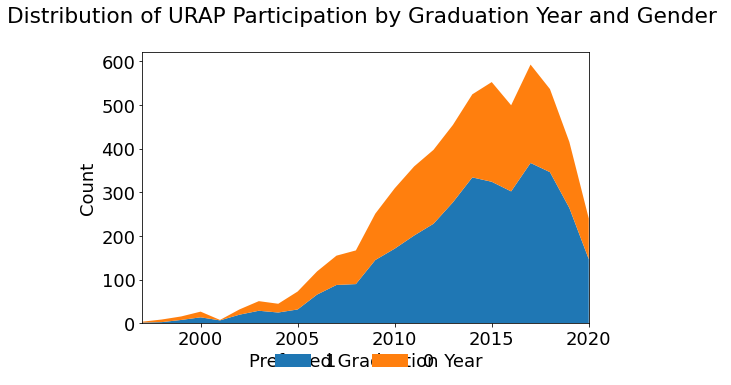

In [973]:
# plotting the counts by different genders over the year
gender_by_year = consolidated.pivot_table(
    values="ID",
    index="Gender",
    columns="Class Year",
    aggfunc=len
).fillna(0)

# plt.stackplot(list(gender_by_year.columns), 
#               list(gender_by_year.loc["F"]),
#               list(gender_by_year.loc["M"]),
#               np.array(gender_by_year.loc["X"]) + np.array(gender_by_year.loc["U"]) + np.array(gender_by_year.loc["D"]),
#               labels=["Female", "Male", "Other"],
#               colors=colormap(3)
#              )

sorted_by_desc_gender = consolidated.groupby("Gender").count().sort_values("ID", ascending=False).index
gender_by_year = gender_by_year.loc[sorted_by_desc_gender]

plt.stackplot(list(gender_by_year.columns), np.array(gender_by_year),
              labels=sorted_by_desc_gender,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Gender \n")

plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.28, -0.2), ncol=8,
            borderaxespad=0, frameon=False)

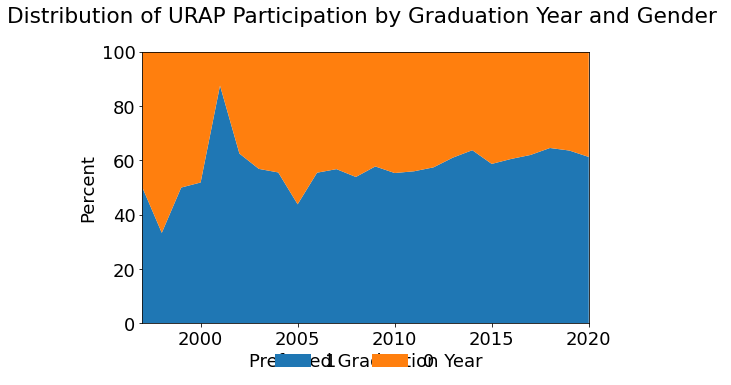

In [974]:
# plotting the percentages by different ethnicities/races over the year
gender_by_year = normalize(gender_by_year, True)

plt.stackplot(list(gender_by_year.columns), np.array(gender_by_year),
              labels=sorted_by_desc_gender,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of URAP Participation by Graduation Year and Gender \n")

plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.28, -0.2), ncol=8,
            borderaxespad=0, frameon=False)

In [975]:
# plotting the counts by different ethnicities/races AND gender over the year
def switch(string):
    if string == 'F':
        return "Female"
    elif string == 'M':
        return "Male"
    else:
        return "Other"

consolidated["Simple Gender"] = consolidated["Gender"].apply(switch)
consolidated["Ethnicity and Gender"] = consolidated["Ethnicity"] + " " + consolidated["Simple Gender"]

ethnicity_gender = consolidated.pivot_table(
    values="ID",
    index="Ethnicity and Gender",
    columns="Class Year",
    aggfunc=len
).fillna(0)

ethnicity_gender_counts = consolidated.groupby("Ethnicity and Gender").count()["ID"].rename("Count")
ethnicity_gender["Counts"] = ethnicity_gender_counts
eg = ethnicity_gender.sort_values("Counts", ascending=False).drop(columns=["Counts"])

plt.stackplot(list(eg.columns), np.array(eg), 
              labels=list(eg.index), 
              colors=colormap(len(list(eg.index)), True)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity & Gender \n")

plt.xlim([min(eg.columns), max(eg.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.00, -0.7), ncol=3,
            borderaxespad=0, frameon=False)

KeyError: 'Ethnicity'

In [ ]:
# plotting the percentages by different ethnicities/races AND gender over the year
eg = normalize(eg, True)

plt.stackplot(list(eg.columns), np.array(eg), 
              labels=list(eg.index), 
              colors=colormap(len(list(eg.index)), True)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percentage")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity & Gender \n")

plt.xlim([min(eg.columns), max(eg.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.00, -0.7), ncol=3,
            borderaxespad=0, frameon=False)

#### Analysis: Top majors per race/gender breakdown.
Only extracting degrees that follow the format of `B.A./B.S. {Degree} YYYY` Pattern.

In [976]:
# consolidated.set_index('ID')["Degrees"].str.split(';').explode()

In [977]:
def get_top_n(top_n, get_other=False):
    # gets the top_n degrees by count and filters resulting table to only have these top degrees
    degree_extract = consolidated.set_index('ID')["Degrees"].str.split(';').explode().str.extract(r"(B\.A\.|B\.S\.) (.+)+\d{4}").reset_index()

    exploded_degree = consolidated.merge(degree_extract.rename(columns={1: "Degree"}), on="ID", how="outer")
    
    # hardcoding replacement of certain majors
    exploded_degree['Degree'] = exploded_degree["Degree"].replace('Electrical Engr & Comp Sci: Undergrad ',
                                                                  'Elec. Engr. CS').replace('Molecular & Cell Bio: Cell & Development ', 
                                                                                  'MCB: Cell & Dev.')
    
    top_n_degrees = exploded_degree.groupby("Degree").count().sort_values("ID", ascending=False)[:top_n]
    percent_captured = sum(top_n_degrees["ID"])/len(exploded_degree) * 100
    print(f"Top {top_n} Degrees capture {percent_captured}% of the data.")
    
    top_n_degrees = list(top_n_degrees.index)

    if get_other:
        only_top_degrees_df = exploded_degree#[exploded_degree["Degree"].isin(top_n_degrees)]
        
        # if we want to preserve the other degrees
        temp = only_top_degrees_df.copy(deep=True)
        non_top = temp[~(temp["Degree"].isin(top_n_degrees))]
        non_top.loc[:, "Degree"] = "Other"
        
        only_top_degrees_df = pd.concat([temp[temp["Degree"].isin(top_n_degrees)], non_top])
        top_n_degrees += ["Other"]
    else:
        only_top_degrees_df = exploded_degree[exploded_degree["Degree"].isin(top_n_degrees)]
    
    return top_n_degrees, only_top_degrees_df, percent_captured, exploded_degree

In [978]:
# plotting the top 15 degrees and getting the breakdown by ethnicity by count
top_n = 15

top_n_degrees, only_top_degrees, percent_captured, exploded_degree = get_top_n(top_n, False)

top_degrees_ethnicity = only_top_degrees.pivot_table(
    values="ID",
    index="Degree",
    columns="Ethnicity",
    aggfunc=len
).fillna(0)

top_degrees_ethnicity = top_degrees_ethnicity.loc[top_n_degrees]

majors = top_degrees_ethnicity.index
# ethnicity order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Ethnicity").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_ethnicity))
i = 0

for ethnicity in options:
    plt.bar(majors, top_degrees_ethnicity[ethnicity], bottom=prev, label=ethnicity)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_ethnicity[ethnicity])
    i += 1

plt.ylabel('Count')
plt.title("Top {n} Majors Breakdown by Ethnicity \n (Captures {percent:.2f}% of all Data) \n\n\n\n".format(n=top_n, percent=percent_captured))
plt.xticks(rotation = 90)

plt.legend(loc='lower left', bbox_to_anchor= (0.05, 1.05), ncol=4,
            borderaxespad=0, frameon=False)

plt.show()

KeyError: 'Degrees'

In [979]:
# plotting the top 15 degrees and getting the breakdown by ethnicity by percentages
top_degrees_ethnicity = normalize(top_degrees_ethnicity, percent=True, axis=1)

majors = top_degrees_ethnicity.index
# ethnicity order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Ethnicity").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_ethnicity))
i = 0

for ethnicity in options:
    plt.bar(majors, top_degrees_ethnicity[ethnicity], bottom=prev, label=ethnicity)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_ethnicity[ethnicity])
    i += 1

plt.ylabel('Percent')
plt.title("Top {n} Majors Breakdown by Ethnicity \n (Captures {percent:.2f}% of all Data) \n\n\n\n".format(n=top_n, percent=percent_captured))
plt.legend()
plt.xticks(rotation = 90)

plt.legend(loc='lower left', bbox_to_anchor= (0.05, 1.05), ncol=4,
            borderaxespad=0, frameon=False)

plt.show()

NameError: name 'top_degrees_ethnicity' is not defined

In [980]:
# plotting the top 15 degrees and getting the breakdown by gender by count

top_degrees_gender = only_top_degrees.pivot_table(
    values="ID",
    index="Degree",
    columns="Gender",
    aggfunc=len
).fillna(0)

top_degrees_gender = top_degrees_gender.loc[top_n_degrees]

majors = top_degrees_gender.index
# gender order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_gender))
i = 0

for gender in options:
    plt.bar(majors, top_degrees_gender[gender], bottom=prev, label=gender)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_gender[gender])
    i += 1

plt.ylabel('Count')
plt.title("Top {n} Majors Breakdown by Gender \n (Captures {percent:.2f}% of all Data) \n\n\n".format(n=top_n, percent=percent_captured))
plt.legend()
plt.xticks(rotation = 90)
plt.ylim([0, 750])

plt.legend(loc='lower left', bbox_to_anchor= (0.29, 1.05), ncol=5,
            borderaxespad=0, frameon=False)

plt.show()

NameError: name 'only_top_degrees' is not defined

In [897]:
# plotting the top 15 degrees and getting the breakdown by gender by gender
top_degrees_gender = normalize(top_degrees_gender, percent=True, axis=1)

majors = top_degrees_gender.index
# gender order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_gender))
i = 0

for gender in options:
    plt.bar(majors, top_degrees_gender[gender], bottom=prev, label=gender)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_gender[gender])
    i += 1

plt.ylabel('Percent')
plt.title("Top {n} Majors Breakdown by Gender \n (Captures {percent:.2f}% of all Data) \n\n\n".format(n=top_n, percent=percent_captured))
plt.legend()
plt.xticks(rotation = 90)
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.29, 1.05), ncol=5,
            borderaxespad=0, frameon=False)

plt.show()

NameError: name 'top_degrees_gender' is not defined

In [898]:
exploded_degree.pivot_table(
    values="Class Year",
    index="Degree",
    columns=["Ethnicity", "Gender"],
    aggfunc=len
).fillna("")

NameError: name 'exploded_degree' is not defined

In [899]:
# plotting the count of the top 10 degrees in the URAP program over the years
top_n = 10

top_n_degrees, only_top_degrees, percent_captured, _ = get_top_n(top_n, False)

df = only_top_degrees

df_by_year = df.pivot_table(
    values="ID",
    index="Degree",
    columns="Class Year",
    aggfunc=len
).fillna(0)

sorted_by_desc = df.groupby("Degree").count().sort_values("ID", ascending=False).index
df_by_year = df_by_year.loc[sorted_by_desc]

plt.stackplot(list(df_by_year.columns), np.array(df_by_year),
              labels=sorted_by_desc,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of Top {n} Majors in URAP by Year\n (Captures {percent:.2f}% of all Data) \n".format(n=top_n, percent=percent_captured))


plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.1, -0.4), ncol=3,
            borderaxespad=0, frameon=False)

KeyError: 'Degrees'

In [ ]:
# plotting the percentages of the top 10 degrees in the URAP program over the years
df_by_year = normalize(df_by_year, True)

plt.stackplot(list(df_by_year.columns), np.array(df_by_year),
              labels=sorted_by_desc,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of Top {n} Majors in URAP by Year\n (Captures {percent:.2f}% of all Data) \n".format(n=top_n, percent=percent_captured))

plt.xlim([min(eg.columns), max(eg.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.1, -0.4), ncol=3,
            borderaxespad=0, frameon=False)

## Persistence Analysis

### Calculating Percentages of Persistence
For the 4 combinations resulting from `Is STEM Degree` (1/0) and `STEM Job Within 5 Years` (1/0), find gender, race, and year breakdown
* For `STEM Job Within 5 Years`, if they didn't get a job, leave it as a NaN. For now, we will consider NaN as a False though drop the people who didn't get a job
    * May want to drop the NaN values though

In [ ]:
def groupby_metrics(df):
    temp = df.groupby(["Ethnicity", "Gender"]).count()#.agg(sum)#.sort_values("Is STEM Degree", ascending=False)
#     temp["% Persist"] = (temp["STEM Job Within 5 Years"]/temp["Is STEM Degree"]) * 100
    return temp["ID"]

In [ ]:
# STEM Ugrad AND STEM 5 years
ugrad_1_job_1 = consolidated[(consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] == 1)]

# STEM Ugrad AND NO STEM 5 years
ugrad_1_job_0 = consolidated[(consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] != 1)]

# NO STEM Ugrad AND STEM 5 years
ugrad_0_job_1 = consolidated[(consolidated["Is STEM Degree"] != 1) & (consolidated["STEM Job Within 5 Years"] == 1)]

# NO STEM Ugrad AND NO STEM 5 years
ugrad_0_job_0 = consolidated[(consolidated["Is STEM Degree"] != 1) & (consolidated["STEM Job Within 5 Years"] != 1)]

In [ ]:
# combining the previous 4 tables
a = pd.DataFrame(groupby_metrics(ugrad_1_job_1))
b = pd.DataFrame(groupby_metrics(ugrad_1_job_0))
c = pd.DataFrame(groupby_metrics(ugrad_0_job_1))
d = pd.DataFrame(groupby_metrics(ugrad_0_job_0))
combinations = pd.concat([a, b, c, d], axis = 1, keys = ["STEM Ugrad STEM Job", "STEM Ugrad NonSTEM Job", 
                                                         "NonSTEM Ugrad STEM Job", "NonSTEM Ugrad NonSTEM Job"]).fillna("")
combinations

In [ ]:
# looking for % persisting based on ugrad STEM Degree
df = consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Ethnicity", "Gender"]).agg(sum)#.sort_values("Is STEM Degree", ascending=False)
df["% Persist"] = (df["STEM Job Within 5 Years"]/df["Is STEM Degree"]) * 100
# df.sort_values("STEM Job Within 5 Years", ascending=False)
df

In [ ]:
df = consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Ethnicity", "Gender"]).agg(sum).sort_values("Is STEM Degree", ascending=False)
df["% Persist"] = (df["STEM Job Within 5 Years"]/df["Is STEM Degree"]) * 100
df

In [ ]:
consolidated.groupby("Class Year").count().sort_values("ID", ascending=False)

### Visualizing Persistence Data

In [ ]:
donut_gender =consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Gender", "STEM Job Within 5 Years"]).count().sort_values("Gender").reset_index()

#manually added from donut_gender:
#nested persistence: [[Female No Persist, Female Persist], [Male No Persist, Male Persist], etc.]
nested_gen = np.array([[700, 1514], [482, 1347], [23, 27]])

#Persistence: [Female, Male]
persist_gen = [1514, 1347]
nopersist_gen = [700, 482]

In [ ]:
fig, ax = plt.subplots()

size = .6

#labels
group_names=["Female", "Male", "Other"]
subgroup_names = ["NP", "P",
                 "NP", "P",
                 "NP", "P"]
#colors
cmap = plt.get_cmap("tab20c")
b, g, r, o, p, grey=[plt.cm.Blues, plt.cm.Greens,plt.cm.Reds,  plt.cm.Oranges,
        plt.cm.Purples, plt.cm.Greys]
outer_colors = [b(0.6), #female
                o(0.6), #male
                g(0.6)] #U and X
inner_colors = [b(0.5), b(0.3), 
                           o(0.5), o(0.3), 
                           g(0.5), g(0.3)]

#graph nested pie
ax.pie(nested_gen.sum(axis=1), labels = group_names, radius=2.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(nested_gen.flatten(), labels = subgroup_names, radius=2.5-size,labeldistance=.8, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
ax.set_title("STEM Persistence By Gender", y=1.7)
plt.show()

In [ ]:
gen = ["Female", "Male"]
ind = [x for x, _ in enumerate(gen)]

#set figure size and plot stacked bar chart
plt.figure(figsize=(8, 8))
plt.bar(ind, persist_gen, label='Persisted')
plt.bar(ind, nopersist_gen, label='Not Persisted', bottom=persist_gen)

#labels
plt.xticks(ind, gen)
plt.ylabel("Count")
plt.xlabel("Gender")
plt.legend(loc='lower left', bbox_to_anchor= (0.15, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Gender (Count)\n\n\n")
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

In [ ]:
#set figure size
plt.figure(figsize=(8, 8))

#percent graph, so total the counts to get percent of persistence 
total = np.array(nopersist_gen) + np.array(persist_gen)
proportion_per_gen = np.true_divide(persist_gen, total) * 100
proportion_noper_gen = np.true_divide(nopersist_gen, total) * 100

#plot stacked bars, with % persistence on bottom
plt.bar(ind, proportion_per_gen,label='Persisted')
plt.bar(ind, proportion_noper_gen, label='Not Persisted', bottom=proportion_per_gen)

#label graphs
plt.xticks(ind, gen)
plt.ylabel("Percent")
plt.xlabel("Gender")
plt.legend(loc='lower left', bbox_to_anchor= (0.15, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Gender (Percent) \n\n\n")

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.ylim([0, 100])

plt.show()

In [ ]:
#STEM degree only grouped by Ethnicity
stem_race =consolidated[(consolidated["Is STEM Degree"] == 1)].groupby("Ethnicity").count().sort_values("Class Year").reset_index()
#then, grouped again by whether or not persisted
donut_race = consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Ethnicity", "STEM Job Within 5 Years"]).count()

#manually added from donut_race:
nested_eth = np.array([[29, 68], [83, 158], [79, 174], [380, 768], [641, 1713]])

In [ ]:
#create a df with individuals with stem degrees who persiseted by race
persist_race = consolidated[(consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] == 1)].groupby(["Ethnicity"]).count().sort_values("Class Year", ascending = False).reset_index()

#create a df with individuals with stem degrees who DID NOT persist by race
nopersist_race = consolidated[((consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] == 0))].groupby(["Ethnicity"]).count().sort_values("Class Year", ascending = False).reset_index()


#merge the two into 1
persistence_race = persist_race[["Ethnicity", "Class Year"]].merge(nopersist_race[["Ethnicity", "Class Year"]], left_on = "Ethnicity", right_on = "Ethnicity", how = "inner")
persistence_race.rename(columns={"Class Year_x": "Persist", "Class Year_y": "Not Persist"}, inplace = True)

#counts of each group
persist_names = persist_race["Ethnicity"]
persist_size= persistence_race["Persist"]
nopersist_size = persistence_race["Not Persist"]

#create percentages of each nopersist group
nopersist_percent = [str(round((number / sum(nopersist_size)*100 ),2)) + "%" for number in nopersist_size]

In [ ]:
#STEM Majors by race, then persistence by job attainment in 5 years 
fig, ax = plt.subplots()
size = .6

#labels
group_names=['Other', 'Chicano/Latino', "Decline to State", "White", "Asian"]
subgroup_names = ["NP", "P",
                 "NP", "P",
                 "NP", "P",
                 "NP", "P",
                 "NP", "P"]
#colors
cmap = plt.get_cmap("tab20c")

outer_colors = [grey(0.6), #other
                g(0.6), #Chicano/Latino
                r(0.6), #Decline
                o(0.6), #White
                b(0.6)] #asian
inner_colors = [grey(0.5), grey(0.3),
                g(0.5), g(0.3),
                r(0.5), r(0.3),
                o(0.5), o(0.3),
                b(0.5), b(0.3)]

#plot both pie graphs, nested
ax.pie(nested_eth.sum(axis=1), labels = group_names, radius=2.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
ax.pie(nested_eth.flatten(), labels = subgroup_names, radius=2.5-size,labeldistance=.8, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

#title
ax.set(aspect="equal")
ax.set_title("STEM Persistence By Ethnicity", y=1.7)

plt.show()

In [ ]:
ind = [x for x, _ in enumerate(persist_names)]

#plot stacked bar with persisetnce on bottom
plt.bar(ind, persist_size, width=0.8, label='Persisted')
plt.bar(ind, nopersist_size, width=0.8, label='Not Persisted', bottom=persist_size)

#labels
plt.xticks(ind, persist_names)
plt.ylabel("Count")
plt.xlabel("Ethnicities")
plt.legend(loc='lower left', bbox_to_anchor= (0.35, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Race\n\n\n")
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

In [ ]:
#side by side stem persistence by race

N = 8

ind = np.arange(N) 
width = 0.35

#race persisted

plt.bar(ind + width, (persist_size), width,
    label='Persist')
plt.bar(ind, nopersist_size
, width, label='Do Not Persist')

plt.ylabel('Counts')
plt.title('STEM Persistence by Race')

plt.xticks(ind + width / 2, persist_names)
plt.yticks(np.arange(0, 2000, 250), np.arange(0, 2000, 250))
plt.legend(loc='best')
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

In [ ]:
#graph by percents

#sum numbers, turn to percents
total = persist_size + nopersist_size
proportion_persist = np.true_divide(persist_size, total) * 100
proportion_nopersist = np.true_divide(nopersist_size, total) * 100

#plot stacked bar, persistence on bottom (blue)
plt.bar(ind, proportion_persist, width=0.8, label='Persisted')
plt.bar(ind, proportion_nopersist, width=0.8, label='Not Persisted', bottom=proportion_persist)

#labels
plt.xticks(ind, persist_names)
plt.ylabel("Percent")
plt.xlabel("Ethnicities")
plt.legend(loc='lower left', bbox_to_anchor= (0.35, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Race\n\n\n")

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.ylim([0, 100])

plt.show()

In [ ]:
#Pie chart: Each race has its own circle with persistence %
t = persist_race.sort_values("Ethnicity")["Ethnicity"]
labels = ["Persisted", "Not Persisted"]
sizes = proportion_persist 

for i in np.arange(0, 8, 1):
    fig1, ax1 = plt.subplots()
    ax1.pie([sizes[i], 100 - sizes[i]], labels=labels, pctdistance=0.40, autopct='%1.1f%%', startangle=90)
    circle = plt.Circle((0,0),0.6,fc='white')
    donut = plt.gcf()
    donut.gca().add_artist(circle)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(str(t[i]))
    plt.show()

In [ ]:
# graphing persistence by both ethnicity and gender
eth_gender = consolidated.copy(deep=True)
FM_only = eth_gender[eth_gender["Gender"].isin(["F", "M"])].reset_index()

FM_persist = FM_only.pivot_table(
    values="ID",
    index="Ethnicity and Gender",
    columns="STEM Job Within 5 Years",
    aggfunc=len
).fillna(0).rename(columns={0: "Not Persisted", 1:"Persisted"})[["Persisted", "Not Persisted"]]

eth_genders = FM_persist.index
# gender order sorted by decreasing counts of top_n_degrees
options = consolidated.groupby("Ethnicity and Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(FM_persist))
i = 0

plt.figure(figsize=[30, 7.5])

for col in FM_persist.columns:
    plt.bar(eth_genders, FM_persist[col], bottom=prev, label=col)#, color=colormap(len(options))[i])
    prev += np.array(FM_persist[col])
    i += 1

plt.ylabel('Counts')
plt.title("STEM Persistence by Race and Gender\n\n\n")
plt.legend()
plt.xticks(rotation = 90)

plt.legend(loc='lower left', bbox_to_anchor= (0.39, 1.05), ncol=5,
            borderaxespad=0, frameon=False)
plt.show()

In [ ]:
#persistence in ethnicity and gender by percent
FM_persist = normalize(FM_persist, percent=True, axis=1)

eth_genders = FM_persist.index
# gender order sorted by decreasing counts of top_n_degrees
options = consolidated.groupby("Ethnicity and Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(FM_persist))
i = 0

plt.figure(figsize=[30, 7.5])

for col in FM_persist.columns:
    plt.bar(eth_genders, FM_persist[col], bottom=prev, label=col)#, color=colormap(len(options))[i])
    prev += np.array(FM_persist[col])
    i += 1

plt.ylabel('Percent')
plt.title("STEM Persistence by Race and Gender\n\n\n")
plt.legend()
plt.xticks(rotation = 90)
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.39, 1.05), ncol=5,
            borderaxespad=0, frameon=False)
plt.show()

# Appendix
There is some additional data analysis captured here. 

In [ ]:
#STEM OR NON STEM BREAKDOWN

#ethicity --> stem (S) / non stem (NS) --> persist or not persist
fig, ax = plt.subplots()

size = .6
#manual inspection of :consolidated.groupby(["Ethnicity", "Is STEM Degree"]).count().reset_index()
vals = np.array([[5, 8], [9, 10], [15, 24], [84, 81], [405, 311], [182, 311], [1124, 1409], [863, 3005]])
group_names=["Pacific Islander", "Other", "Native American/Alaska Native", "African American", "Chicano/Latino","Decline to State", "White", "Asian"]
subgroup_names = ["N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y"]

cmap = plt.get_cmap("tab20c")
b, g, r, o, p, grey=[plt.cm.Blues, plt.cm.Greens,plt.cm.Reds,  plt.cm.Oranges,
        plt.cm.Purples, plt.cm.Greys]
outer_colors = [b(0.6), #pacific
                                                                      grey(0.6), #other
                                                                      g(0.6), #Native
                                                                      p(0.6), #AA
                                                                      g(0.6), #Chicano/Latino
                                                                      r(0.6), #Decline
                                                                      o(0.6), #White
                                                                      b(0.6)] #asian
inner_colors = [b(0.5), b(0.3), 
                           grey(0.5), grey(0.3), 
                           g(0.5), g(0.3), 
                           p(0.4), p(0.3),
                          g(0.5), g(0.3),
                          r(0.5), r(0.3),
                          o(0.5), o(0.3),
                          b(0.5), b(0.3)]

ax.pie(vals.sum(axis=1), labels = group_names, radius=2.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), labels = subgroup_names, radius=2.5-size,labeldistance=.75, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
plt.show()

Q: What % of men and women for each race/ethnicity went through the program each year?

In [ ]:
consolidated.pivot_table(
    values="ID",
    index=["Ethnicity", "Gender"],
    columns="Class Year",
    aggfunc=len
).fillna("")